In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

print(data.keys())
print(data['det'])

#Downsample the data a lot to speed up representation to visualize the best features, 
# then searching best method for classification with less reduced data. 
# After we find best method and best hyperparameters, we finally analyze the full dataset.

n_samps = 10**3
x_names = ['chi1x']
X_tot = np.array(data['chi1x'][:n_samps], dtype=np.float32)
X_tot = X_tot[:, np.newaxis] 
for name in data.keys():
    if name not in ['chi1x','det', 'snr']:
        x_names.append(name)
        X_tot = np.append(X_tot, data[name][:n_samps].reshape(-1, 1), axis=1)
print(X_tot.shape)
print(x_names)
y = np.array(data['det'][:n_samps], dtype=np.int32)


<KeysViewHDF5 ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']>
<HDF5 dataset "det": shape (20000000,), type "<i8">
(1000, 13)
['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'iota', 'mtot', 'psi', 'q', 'ra', 'z']


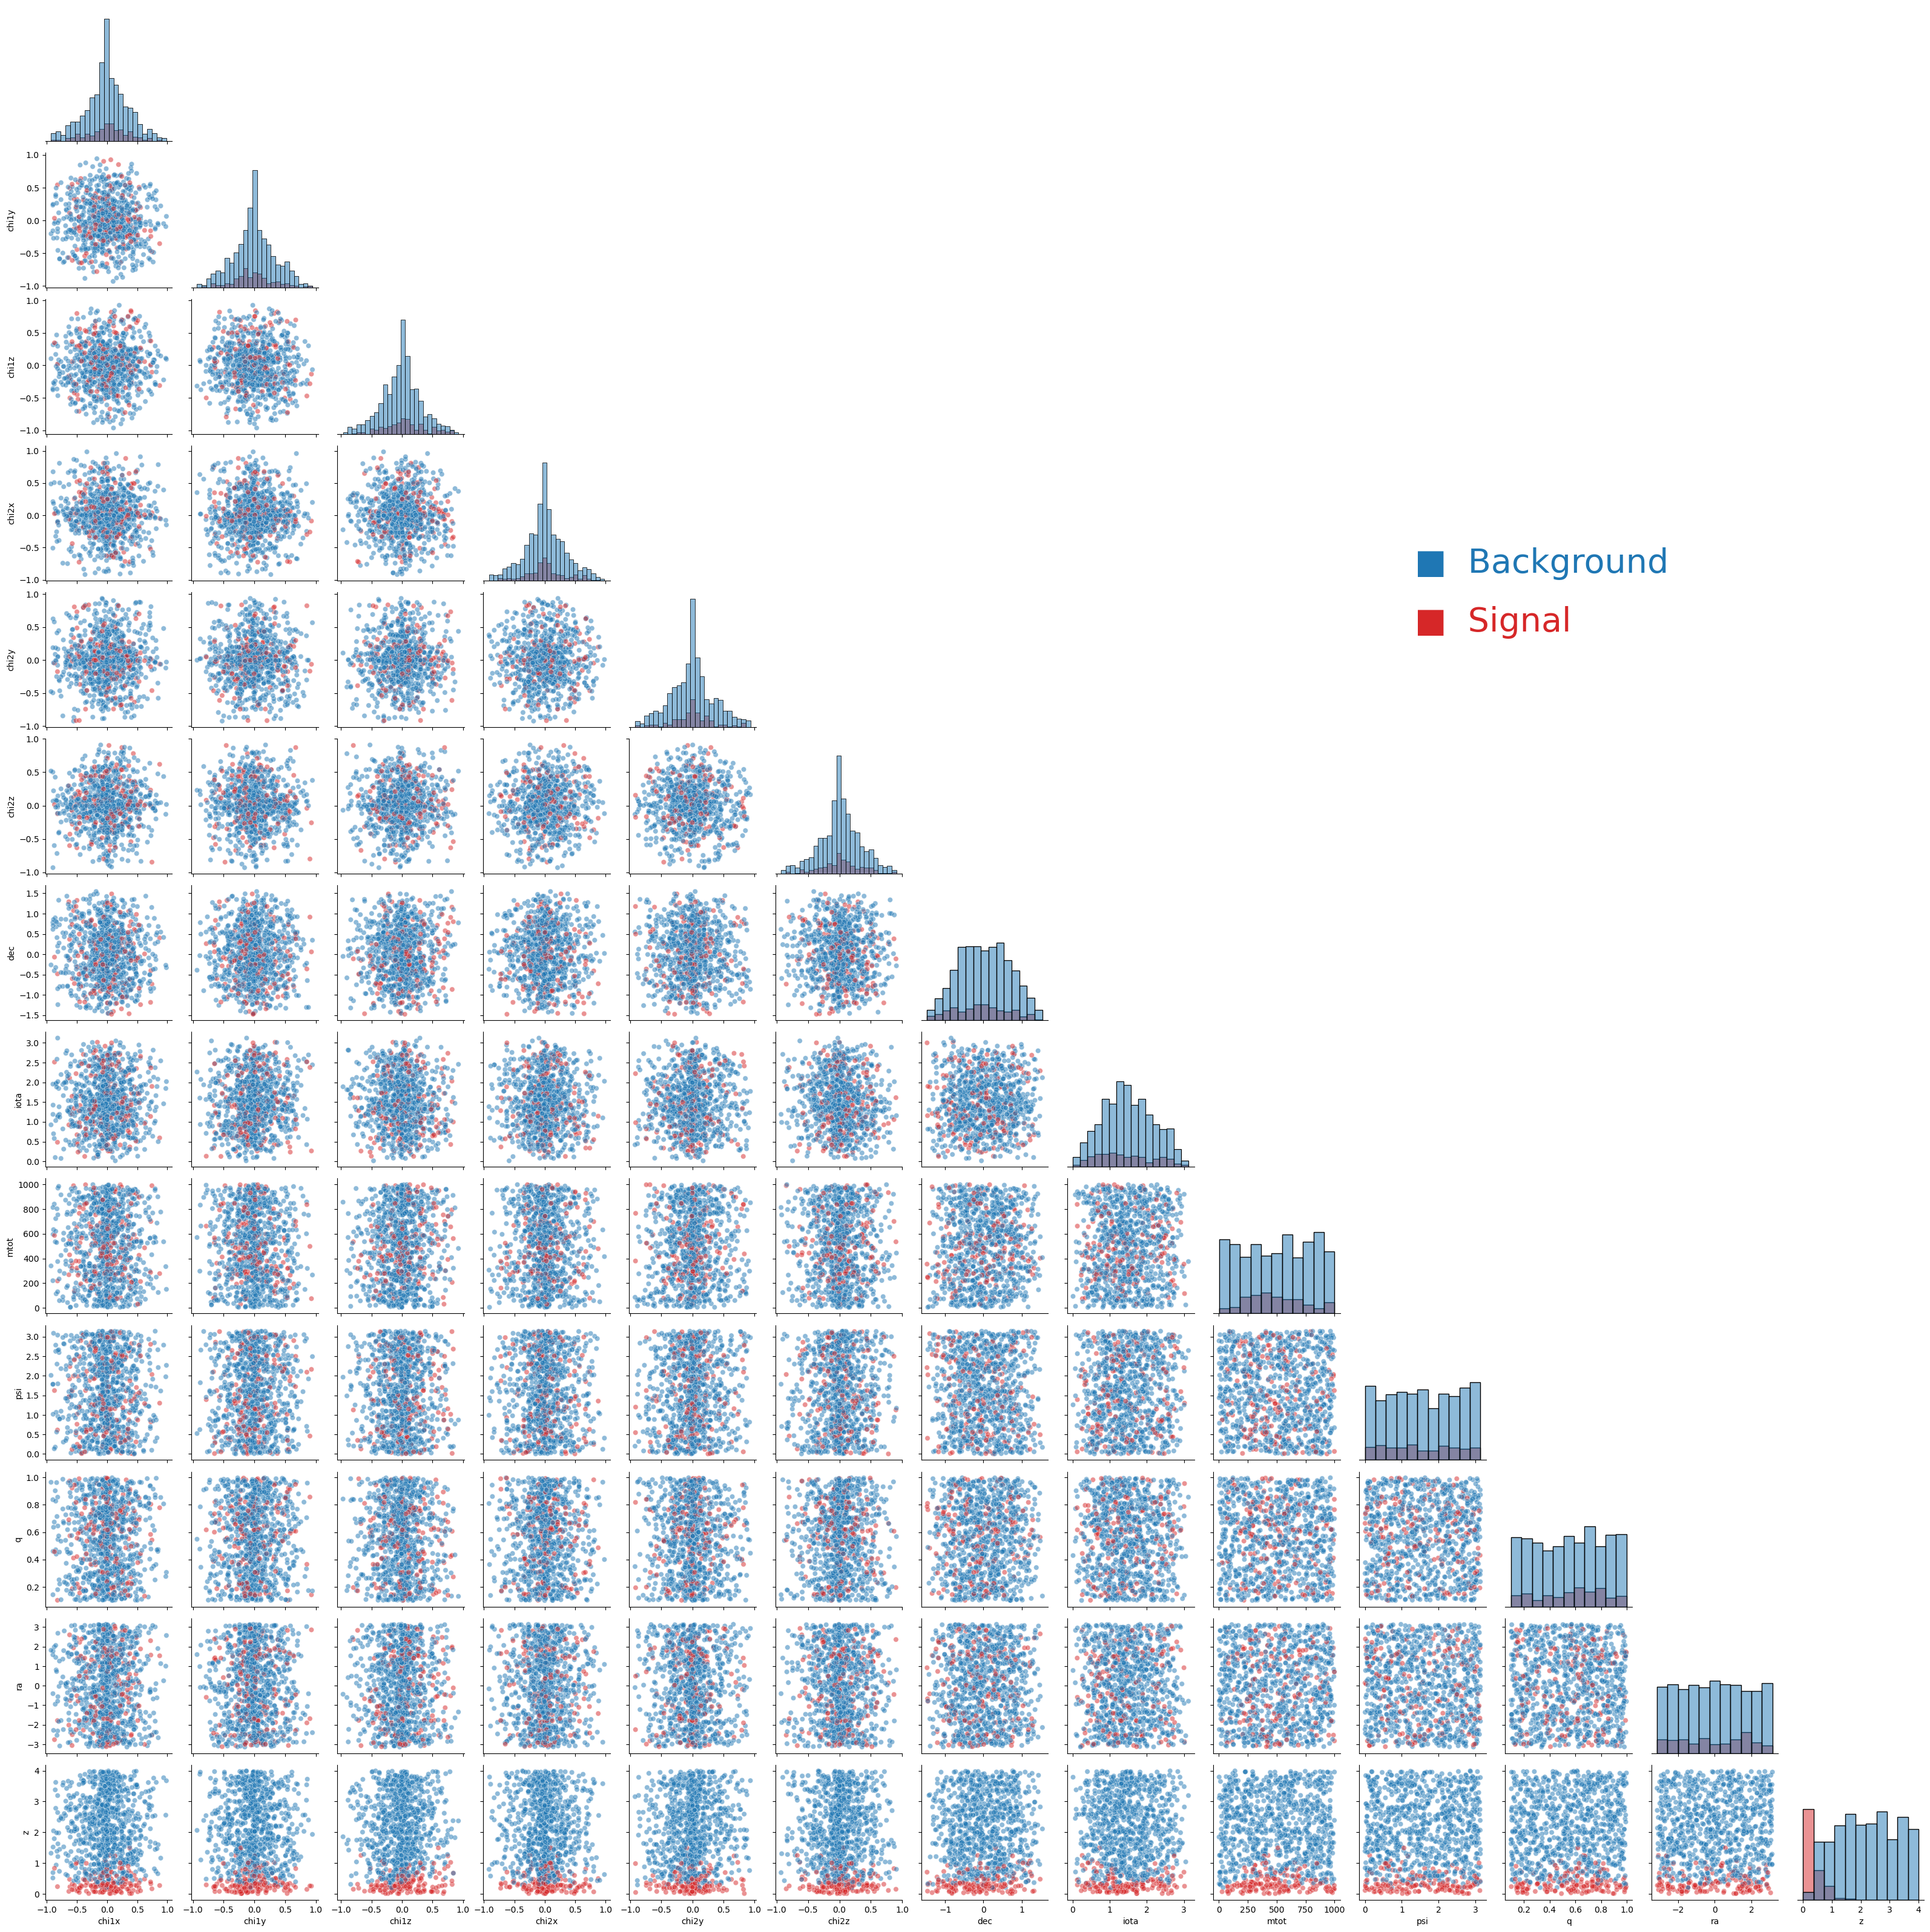

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X_tot, columns=x_names)
labels = np.where(y==0, 'Background', 'Signal') 
df['label'] = labels
custom_palette = {'Background': 'tab:blue', 'Signal': 'tab:red'}

g = sns.pairplot(df, hue='label', diag_kind='hist', palette=custom_palette, corner=True, plot_kws={'alpha': 0.5})
legend_colors = ['tab:blue', 'tab:red'] 
legend_labels = ['Background', 'Signal'] 
g._legend.remove()
# Add simulated legend items (tweak x/y for position)
for i, (label, color) in enumerate(zip(legend_labels, legend_colors)):
    g.figure.text(
        x=0.7,
        y=0.7 - i * 0.03,
        s='■  ' + label,  # ■ simulates a square marker
        transform=g.figure.transFigure,
        fontsize=40,
        color=color
    )



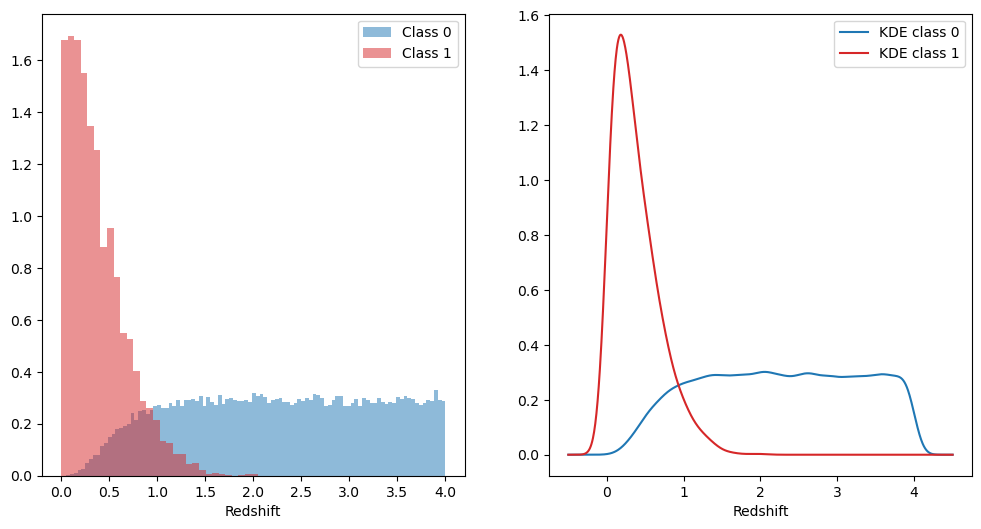

In [3]:
#Redshift seems to be the best feature to distinguish the two classes, so we use it as starting point

#Downsample the data to 1/2000th of the original sample to speed up the selection and implemention of a method od classification
n_samps = 5*10**4
x_names = ['chi1x']
X_tot = np.array(data['chi1x'][:n_samps], dtype=np.float32)
X_tot = X_tot[:, np.newaxis] 
for name in data.keys():
    if name not in ['chi1x','det', 'snr']:
        x_names.append(name)
        X_tot = np.append(X_tot, data[name][:n_samps].reshape(-1, 1), axis=1)

y = np.array(data['det'][:n_samps], dtype=np.int32)



from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tot, y, test_size=0.2, random_state=42)

from sklearn.neighbors import KernelDensity

Xgrid = np.linspace(-0.5, 4.5, 1000)
kde0 =KernelDensity(kernel='gaussian', bandwidth=0.1)
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.1)
kde0.fit(X_train[y_train == 0][:, [12]]) # Fit KDE for class 0
kde1.fit(X_train[y_train == 1][:, [12]]) # Fit KDE for class 1
dens0 = np.exp(kde0.score_samples(Xgrid[:, np.newaxis])) 
dens1 = np.exp(kde1.score_samples(Xgrid[:, np.newaxis]))

fig1, ax1 = plt.subplots(1,2, figsize=(12, 6))
ax1[0].hist(X_train[y_train == 0, 12], bins=100, alpha=0.5, label='Class 0', color='tab:blue', density=True)
ax1[0].hist(X_train[y_train == 1, 12], bins=30, alpha=0.5, label='Class 1', color='tab:red', density=True)
ax1[0].set_xlabel('Redshift')
ax1[0].legend()

ax1[1].plot(Xgrid, dens0, color='tab:blue', label='KDE class 0')
ax1[1].plot(Xgrid, dens1, color='tab:red', label='KDE class 1')
ax1[1].set_xlabel('Redshift')
ax1[1].legend()


In [4]:
#Reorder features to have columns in this order: redshift, mtot, q, psi, chi1x, chi1y, chi1z, chi2x, chi2y, chi2z, iota, dec, ra
X_train = X_train[:,[12, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 11]]
X_test = X_test[:,[12, 8, 9, 10, 0, 1, 2, 3, 4, 5, 6, 7, 11]]
x_names = ['z', 'mtot', 'q', 'psi', 'chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'iota', 'dec', 'ra']

Best number of features: 13 with accuracy: 0.949


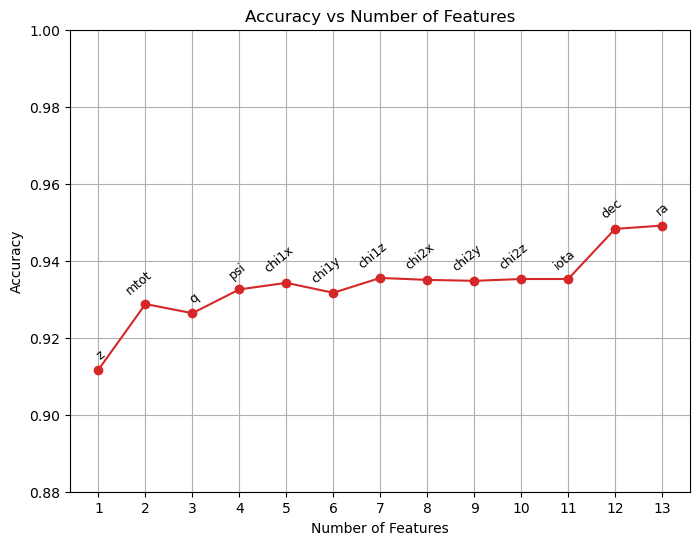

In [5]:
from sklearn.tree import DecisionTreeClassifier
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=42)
scores = np.array(())
for n in range(1, 14):
    score = cross_val_score(clf_tree, X_train[:,:n], y_train, cv=5, scoring='accuracy')
    scores = np.append(scores, score.mean())
print(f"Best number of features: {np.argmax(scores) + 1} with accuracy: {scores.max():.3f}")


fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.plot(range(1, 14), scores, label='True rate', marker='o', color= 'tab:red')
for i, name in enumerate(x_names):
    ax2.text(i+1+0.2, scores[i]+0.002, name, rotation=40, ha='right', va='bottom', fontsize=9)
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs Number of Features')
ax2.set_ylim([0.88, 1.0])
ax2.set_xticks(range(1, 14))

ax2.grid()

In [6]:

score = cross_val_score(clf_tree, X_train[:,[0,1,3, 11,]], y_train,cv = 5, scoring='accuracy')
score = np.mean(score)
print(f"Accuracy with subset of feature (z, mtot, psi, dec): {score:.3f}")

print("\nEven using what seem to be the best features, using all 13 gives the best performance, so we are gonna use all of them")

Accuracy with subset of feature (z, mtot, psi, dec): 0.948

Even using what seem to be the best features, using all 13 gives the best performance, so we are gonna use all of them


In [7]:

#Confronting result with gini impurity
clf_tree_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
score_gini = cross_val_score(clf_tree_gini, X_train, y_train,cv = 5, scoring='accuracy')
score_gini = np.mean(score_gini)
print(f"\nGini accuracy: {score_gini:.3f}")
print("\nGini does not improve performance")


Gini accuracy: 0.946

Gini does not improve performance


[0.944475 0.94555  0.9498   0.9521   0.951775 0.953125 0.953125 0.952275
 0.95115  0.94995  0.949825 0.94975  0.949175 0.94955  0.949275 0.9489  ]
Best depth: 10
Confusion Matrix:
 [[8377  241]
 [ 221 1161]]
Decision Tree accuracy: 0.954
Completeness: 0.840, Precision: 0.828


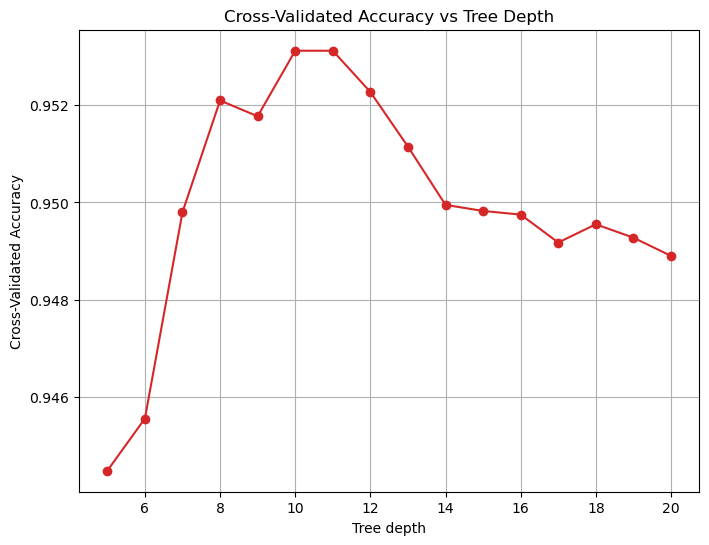

In [7]:
#Using cross validation to find the best depth for the decision tree classifier
depths = np.arange(5, 21)
scores_tree = np.array(())
for depth in depths:
    clf_tree = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
    score = cross_val_score(clf_tree, X_train, y_train, cv=5, scoring='accuracy')
    scores_tree = np.append(scores_tree, score.mean())
print(scores_tree)
best_depth = depths[np.argmax(scores_tree)]
print(f"Best depth: {best_depth}")
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.plot(depths, scores_tree, marker='o', color='tab:red')
ax3.set_xlabel('Tree depth')
ax3.set_ylabel('Cross-Validated Accuracy')
ax3.set_title('Cross-Validated Accuracy vs Tree Depth')
ax3.grid()

clf_tree = DecisionTreeClassifier(max_depth=best_depth, criterion='entropy', random_state=42)
clf_tree.fit(X_train, y_train)
y_pred_tree = clf_tree.predict(X_test)
y_prob_tree = clf_tree.predict_proba(X_test)[:, 1]
conf_mat_tree = confusion_matrix(y_pred_tree, y_test)
print("Confusion Matrix:\n", conf_mat_tree)
accuracy_tree = conf_mat_tree.trace() / len(y_test)
print(f"Decision Tree accuracy: {accuracy_tree:.3f}")
comp_tree, cont_tree = completeness_contamination(y_test, y_pred_tree)
print(f"Completeness: {comp_tree:.3f}, Precision: {1-cont_tree:.3f}")
fpr_tree, tpr_tree, thresh_tree = roc_curve(y_test, y_prob_tree)

In [8]:
#Compute the accuracy of a bagging classifier
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=42),
        n_estimators=500, n_jobs=-1,bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
y_prob_bag = bag_clf.predict_proba(X_test)[:,1]
conf_mat_bag = confusion_matrix(y_pred_bag, y_test)
print("Confusion Matrix:\n", conf_mat_bag)
accuracy_bag = conf_mat_bag.trace() / len(y_test)
print(f"Decision Tree accuracy: {accuracy_bag:.3f}")
comp_bag, cont_bag = completeness_contamination(y_test, y_pred_bag)
print(f"Completeness: {comp_bag:.3f}, Precision: {1-cont_bag:.3f}")
fpr_bag, tpr_bag, thresh_bag = roc_curve(y_test, y_prob_bag)

Confusion Matrix:
 [[8458  201]
 [ 140 1201]]
Decision Tree accuracy: 0.966
Completeness: 0.896, Precision: 0.857


In [10]:
#Trying with Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=500, max_depth=None, criterion='entropy', random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:,1]
conf_mat_rf = confusion_matrix(y_pred_rf, y_test)
print("Confusion Matrix:\n", conf_mat_rf)
accuracy_rf = conf_mat_rf.trace() / len(y_test)
print(f"Decision Tree accuracy: {accuracy_rf:.3f}")
comp_rf, cont_rf = completeness_contamination(y_test, y_pred_rf)
print(f"Completeness: {comp_rf:.3f}, Precision: {1-cont_rf:.3f}")
fpr_rf, tpr_rf, thresh_rf = roc_curve(y_test, y_prob_rf)

Confusion Matrix:
 [[8470  209]
 [ 128 1193]]
Decision Tree accuracy: 0.966
Completeness: 0.903, Precision: 0.851


In [11]:
#At last trying with gradient boosting classifier

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_grid = {
    'max_depth': randint(5,30),
    'max_iter': randint(500, 1000),
    'n_iter_no_change': randint(20,80),
}
hgb_rs = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=42, early_stopping=True),
    param_distributions=param_grid,
    n_iter=30, cv=5, scoring='accuracy', random_state=42, n_jobs=-1
)
hgb_rs.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(early_stopping=True,
                                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240A47C0830>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240A59460D0>,
                                        'n_iter_no_change': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000240A5946210>},
                   random_state=42, scoring='accuracy')

In [12]:

hgb = hgb_rs.best_estimator_
print(f"Best parameters: {hgb_rs.best_params_}")
y_pred_gb = hgb.predict(X_test)
y_prob_gb = hgb.predict_proba(X_test)[:,1]
conf_mat_gb = confusion_matrix(y_pred_gb, y_test)
print("Confusion Matrix:\n", conf_mat_gb)
accuracy_gb = conf_mat_gb.trace() / len(y_test)
print(f"Gradient Boosting accuracy: {accuracy_gb:.3f}")
comp_gb, cont_gb = completeness_contamination(y_test, y_pred_gb)
print(f"Completeness: {comp_gb:.3f}, Precision: {1-cont_gb:.3f}")
fpr_gb, tpr_gb, thresh_gb = roc_curve(y_test, y_prob_gb)

print("This seems to be the best model. higher accuracy, completeness and precision than the others, and it is very fast.")


Best parameters: {'max_depth': 8, 'max_iter': 549, 'n_iter_no_change': 59}
Confusion Matrix:
 [[8495  115]
 [ 103 1287]]
Gradient Boosting accuracy: 0.978
Completeness: 0.926, Precision: 0.918
This seems to be the best model. higher accuracy, completeness and precision than the others, and it is very fast.


We see that Bagging and Random Forest have a very similar ROC curve, both better than Decision Tree, but the best is clearly Gradient Boosting


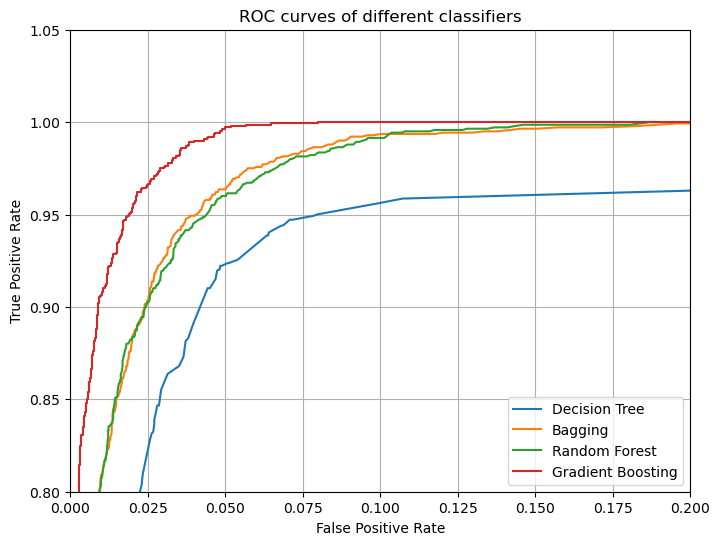

In [13]:

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.plot(fpr_tree, tpr_tree, label='Decision Tree')
ax4.plot(fpr_bag, tpr_bag, label = 'Bagging')
ax4.plot(fpr_rf, tpr_rf, label = 'Random Forest')
ax4.plot(fpr_gb, tpr_gb, label = 'Gradient Boosting')
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_xlim([0,0.2])
ax4.set_ylim([0.8,1.05])
ax4.set_title('ROC curves of different classifiers')
ax4.legend(loc = 'lower right')
ax4.grid()

print("We see that Bagging and Random Forest have a very similar ROC curve, both better than Decision Tree, but the best is clearly Gradient Boosting")

In [14]:
#WE CAN SEE PERFORMANCE ON 5*E5 SET USING BAGGING CLASSIFIER
n_samps = 5*10**5
x_names = ['chi1x']
X_tot = np.array(data['chi1x'][:n_samps], dtype=np.float32)
X_tot = X_tot[:, np.newaxis] 
for name in data.keys():
    if name not in ['chi1x','det', 'snr']:
        x_names.append(name)
        X_tot = np.append(X_tot, data[name][:n_samps].reshape(-1, 1), axis=1)

y = np.array(data['det'][:n_samps], dtype=np.int32)
X_train, X_test, y_train, y_test = train_test_split(X_tot, y, test_size=0.2, random_state=42)

In [15]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
y_prob_bag = bag_clf.predict_proba(X_test)[:,1]
conf_mat_bag = confusion_matrix(y_pred_bag, y_test)
print("Confusion Matrix:\n", conf_mat_bag)
accuracy_bag = conf_mat_bag.trace() / len(y_test)
print(f"Decision Tree accuracy: {accuracy_bag:.3f}")
comp_bag, cont_bag = completeness_contamination(y_test, y_pred_bag)
print(f"Completeness: {comp_bag:.3f}, Precision: {1-cont_bag:.3f}")

Confusion Matrix:
 [[84140  1725]
 [ 1338 12797]]
Decision Tree accuracy: 0.969
Completeness: 0.905, Precision: 0.881


In [16]:

#FINALLY WE CAN SEE PERFORMANCE ON 5*E5 SET USING GRADIENT BOOSTING CLASSIFIER
hgb.fit(X_train, y_train)
y_pred_gb = hgb_rs.predict(X_test)
y_prob_gb = hgb_rs.predict_proba(X_test)[:,1]
conf_mat_gb = confusion_matrix(y_pred_gb, y_test)
print("Confusion Matrix:\n", conf_mat_gb)
accuracy_gb = conf_mat_gb.trace() / len(y_test)
print(f"Gradient Boosting accuracy: {accuracy_gb:.3f}")
comp_gb, cont_gb = completeness_contamination(y_test, y_pred_gb)
print(f"Completeness: {comp_gb:.3f}, Precision: {1-cont_gb:.3f}")



Confusion Matrix:
 [[84775   747]
 [  703 13775]]
Gradient Boosting accuracy: 0.986
Completeness: 0.951, Precision: 0.949
